<a href="https://colab.research.google.com/github/KrzysztofKulesza/DS_Homework/blob/main/DL_project_no_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout,SeparableConv2D, Activation, BatchNormalization, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img
import cv2
import itertools
import pathlib
import warnings
import os
import random
import time
import gc
from IPython.display import Markdown, display
from PIL import Image
from random import randint
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [2]:
# podlaczamy dysk google
from google.colab import drive

# nalezy podac wlasna sciezke
drive.mount('/content/drive')
# sciezka do katalogu
data_path = "/content/drive/MyDrive/DL_project/fruit_images"
banana_path = "/content/drive/MyDrive/DL_project/fruit_images/Banana"
orange_path = "/content/drive/MyDrive/DL_project/fruit_images/Orange"
pitaya_path = "/content/drive/MyDrive/DL_project/fruit_images/Pitaya"
pear_path = "/content/drive/MyDrive/DL_project/fruit_images/Pear"

Mounted at /content/drive


In [3]:
# nalezy załadować dodatkowe - u góry jest tego dużo, ale jeszcze za mało :D
import os
import shutil
from PIL import Image
from keras.preprocessing import image
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

In [ ]:
# Tworzenie bazy danych
#input_shape = (224, 224, 3)
input_shape = (112, 112, 3) #bieda
batch_size = 256
X = []
y = []
# Wczytanie obrazków bananów
for file in os.listdir(banana_path):
  img = load_img(os.path.join(banana_path, file), target_size=input_shape[:2])
  img = img_to_array(img) / 255.0
  X.append(img)
  y.append('banana')  # Oznaczamy jako 0 dla bananów
# Wczytanie obrazków pomarańczy
for file in os.listdir(orange_path):
  img = load_img(os.path.join(orange_path, file), target_size=input_shape[:2])
  img = img_to_array(img) / 255.0
  X.append(img)
  y.append('orange') # Oznaczamy jako 1 dla pomarańczy
# Wczytanie obrazków gruszek
# for file in os.listdir(pear_path):
#   img = load_img(os.path.join(pear_path, file), target_size=input_shape[:2])
#   img = img_to_array(img) / 255.0
#   X.append(img)
#   y.append('pear') # Oznaczamy jako 2 dla gruszek
  for file in os.listdir(pitaya_path):
    img = load_img(os.path.join(pitaya_path, file), target_size=input_shape[:2])
    img = img_to_array(img) / 255.0
    X.append(img)
    y.append('pitaya') # Oznaczamy jako 2 dla pitaya
X = np.array(X)
y = np.array(y)
X.shape, y.shape

In [ ]:
np.array(np.unique(y, return_counts=True)).T

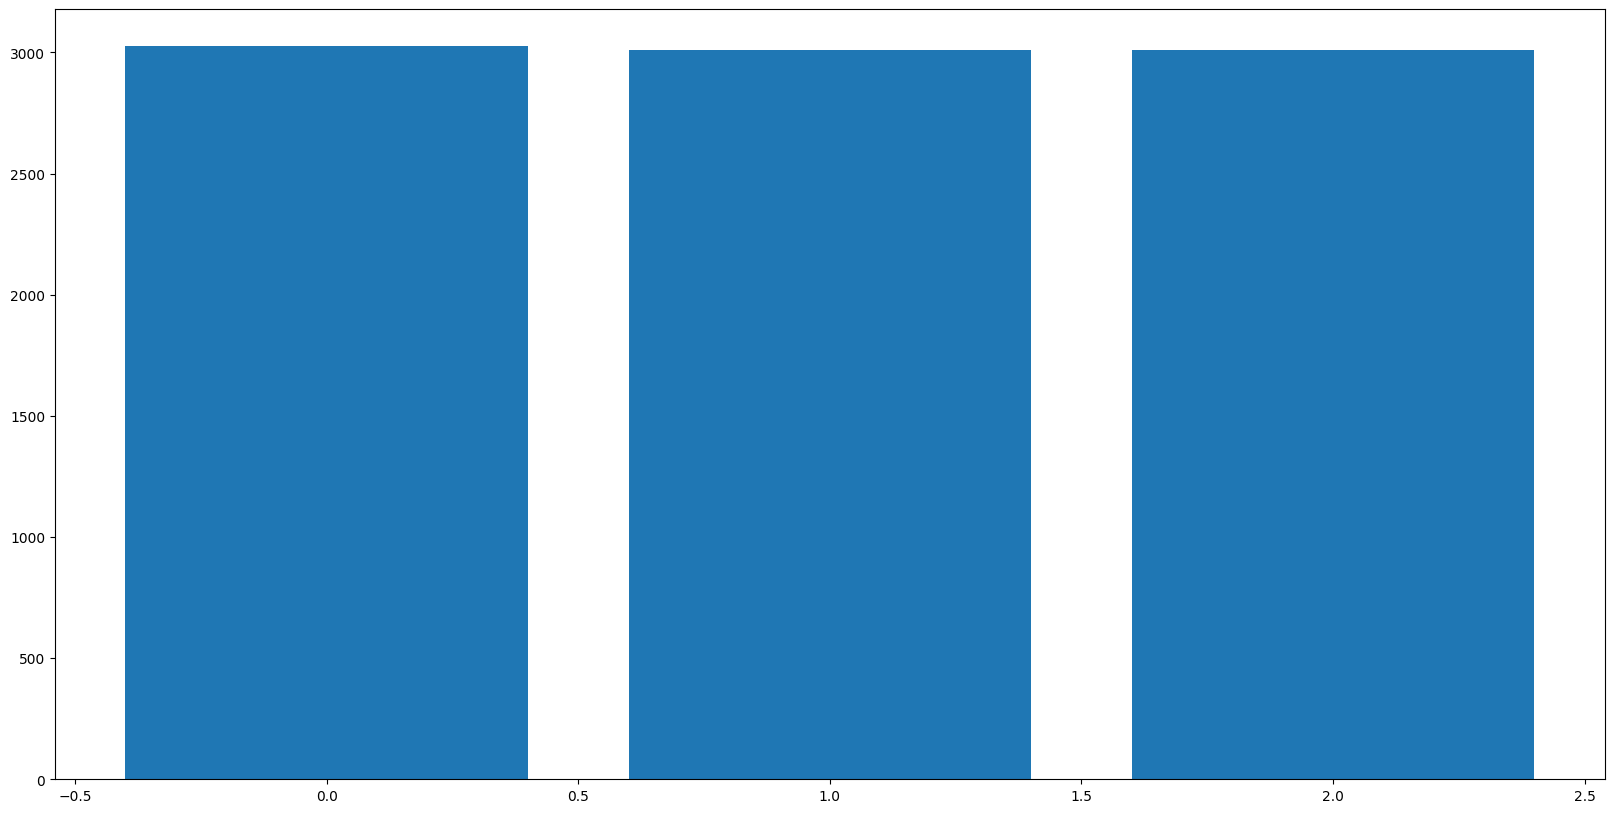

In [ ]:
# policzenia ile jest próbek z każdej klasy
uniques, counts = np.unique(y, return_counts=True)
# wyświetlenie ilości na wykresie
fig = plt.figure(figsize = (20,10))
plt.title('Ilość zdjęć owoców')
plt.bar(uniques, counts)
plt.show()

<Figure size 640x480 with 0 Axes>

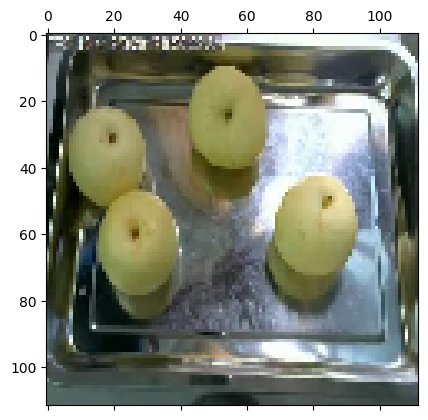

In [ ]:
# pobierzmy przykladowy obrazek
n = 9050
plt.gray()
plt.matshow(X[n])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
num_classes = 3

In [ ]:
from sklearn.preprocessing import OneHotEncoder
# transformujemy y_test
y_test = OneHotEncoder().fit_transform(y_test.reshape(-1,1)).toarray()
# podglądamy
y_test = y_test.astype(np.float32)

# transformujemy y_train
y_train = OneHotEncoder().fit_transform(y_train.reshape(-1,1)).toarray()
# podglądamy
y_train = y_train.astype(np.float32)

print("y_test.shape: ", y_test.shape)
print("y_train.shape: ", y_train.shape)

y_test.shape:  (2716, 3)
y_train.shape:  (6335, 3)


In [ ]:
# zbadamy ile ich jest
print("X_test shape: ", X_test.shape)
print("X_train shape: ", X_train.shape)

X_test shape:  (2716, 112, 112, 3)
X_train shape:  (6335, 112, 112, 3)


In [ ]:
def create_cnn_model(input_shape, conv_num, dense_num, act, output_num, loss):
    """
    :param input_shape: kształt wejścia, h*w*c
    :param conv_num: lista ilości feature'ów w warstwach konwolucyjnych
    :param dense_num: lista ilości neuronów w poszczególnych warstwach ukrytych
    :param act: rodzaj aktywacji w warstwach ukrytych, str
    :param output_num: liczba wyjść
    """
    # pusty model sekwyncyjny
    model = tf.keras.Sequential()
    # warstwa wejściowa
    model.add(layers.InputLayer(input_shape=input_shape))
    # warstwy konowlucyjne+max pool
    for idx, one_conv_filters in enumerate(conv_num):
        # konowlucje
        model.add(
            layers.Conv2D(
                filters=one_conv_filters,
                kernel_size=3,
                strides=1,
                padding="SAME",
                activation=act,
                name="konwolucja_"+str(idx)
            )
        )
        # max pool
        model.add(
            layers.MaxPool2D(
                pool_size=2,
                strides=2,
                padding="SAME",
                name="redukcja_"+str(idx)
            )
        )
        # dropout
        model.add(
            layers.Dropout(0.3)
        )
    # spłaszczenie NxHxWxC => NxK, K-ilość wszystkich featerów
    model.add(layers.Flatten(name="splaszczenie"))
    # warstwy gęste
    for idx, one_dense_units in enumerate(dense_num):
        # dense
        model.add(
            layers.Dense(
                units=one_dense_units,
                activation=act,
                name="gesta_"+str(idx)
            )
        )
        # dropout
        model.add(
            layers.Dropout(0.5)
        )
    # warstwa wyjściowa
    model.add(layers.Dense(output_num, name="wyjscie"))
    # warstwa softmax, tworzy dystrybucję prawdopodobieństwa
    model.add(layers.Softmax())
    # wyświetlenie modelu
    print(model.summary())

    # kompilacja modelu
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=loss,
        metrics=["accuracy"]
    )

    return model

In [ ]:
Model_CNN = create_cnn_model(
    input_shape=X_test.shape[1:],
    conv_num=[16,32,64],
    dense_num=[1024,512],
    act="relu",
    output_num=y_test.shape[1],
    loss=tf.keras.losses.CategoricalCrossentropy()
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 konwolucja_0 (Conv2D)       (None, 112, 112, 16)      448       
                                                                 
 redukcja_0 (MaxPooling2D)   (None, 56, 56, 16)        0         
                                                                 
 dropout (Dropout)           (None, 56, 56, 16)        0         
                                                                 
 konwolucja_1 (Conv2D)       (None, 56, 56, 32)        4640      
                                                                 
 redukcja_1 (MaxPooling2D)   (None, 28, 28, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 32)        0         
                                                                 
 konwolucja_2 (Conv2D)       (None, 28, 28, 64)        1